In [1]:
# #withwith l2 weight decay - NEW oren
from IPython import get_ipython
get_ipython().magic('reset -sf')


import tensorflow as tf
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten,BatchNormalization
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from scipy.misc import imread
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from keras.optimizers import SGD
from keras.models import Model
import cv2
import glob
import pdb
import os
from keras.layers import *
drive.mount('/content/drive')


batch_size = 32
num_classes = 75*2
#epochs = 30
epochs = 60

num_of_img=0

tmp = os.popen("ls drive/'My Drive'/Project/train2/").read().split()
#type(tmp)
num_of_img=0
for line in tmp:
  if 'original' in line:
    num_of_img= num_of_img+1
for line in tmp:
  if 'forgeries' in line:
    num_of_img= num_of_img+1
    
x_train=np.ones((num_of_img, 150,220)) # may neet to be x=np.ones((num_of_img, 150,220,1)) but puts an error
y_train=np.zeros((num_of_img,1))
y_train_f=np.zeros((num_of_img,1))


i=0 
#print(tmp[1320])

#print(len(tmp))
for line in tmp:
  if 'original' in line:
    path="drive/My Drive/Project/train2/"+line
    img = cv2.imread(path,0)
    # Otsu's thresholding
    ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    #new image ---
    new_img=255-img

    #resize the img
    newimg = cv2.resize(new_img,(int(220),int(150)))
    #newimg = cv2.resize(new_img,(int(150),int(220)))
    #print(line)
    #print(i)
    x_train[i,:,:]=newimg
    line_splited=line.split('_')
    y_train[i,:]=int(line_splited[1])-1
    y_train_f[i,:]=0
   # print(y_train[i])
    i=i+1    
    #print(y_train)
  if 'forgeries' in line:
    path="drive/My Drive/Project/train2/"+line
    print(path)
    img = cv2.imread(path,0)
    # Otsu's thresholding
    ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    #new image ----
    new_img=255-img

    
    #resize the img
    newimg = cv2.resize(new_img,(int(220),int(150)))
    #newimg = cv2.resize(new_img,(int(150),int(220)))
    #print(line)
    print(i)
    x_train[i,:,:]=newimg
    line_splited=line.split('_')
    y_train[i,:]=int(line_splited[1])-1+75
    y_train_f[i,:]=1
   # print(y_train[i])
    i=i+1    
    #print(y_train)
    
y_train_for_svm=y_train
    
tmp = os.popen("ls drive/'My Drive'/Project/test2/").read().split()
#type(tmp)
num_of_img=0    
j=0
#print(tmp[1320])
for line in tmp:
  if 'original' in line:
    num_of_img= num_of_img+1
for line in tmp:
  if 'forgeries' in line:
    num_of_img= num_of_img+1
    
    
y_test_f=np.zeros((num_of_img,1))
x_test=np.ones((num_of_img, 150,220)) # may neet to be x=np.ones((num_of_img, 150,220,1)) but puts an error
y_test=np.zeros((num_of_img,1))

#print(len(tmp))
for line in tmp:
  if 'original' in line:
    path="drive/My Drive/Project/test2/"+line
    img = cv2.imread(path,0)
    # Otsu's thresholding
    ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    #new image
    new_img=255-img
    #resize the img
    newimg = cv2.resize(new_img,(int(220),int(150)))
    #print(line)
    #print(i)
    x_test[j,:,:]=newimg
    line_sploted=line.split('_')
    y_test[j]=int(line_sploted[1])-1
    y_test_f[j,:]=0
   # print(y_train[i])
    j=j+1 
  if 'forgeries' in line:
    path="drive/My Drive/Project/test2/"+line
    img = cv2.imread(path,0)
    # Otsu's thresholding
    ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    #new image
    new_img=255-img

    #resize the img
    newimg = cv2.resize(new_img,(int(220),int(150)))
    #print(line)
    print(j)
    x_test[j,:,:]=newimg
    line_sploted=line.split('_')
    y_test[j]=int(line_sploted[1])-1+75
    y_test_f[j,:]=1
   # print(y_train[i])
    j=j+1  

y_test_for_svm=y_test

# input image dimensions
img_rows, img_cols = 150,220
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255


#print('x_train shape:', x_train.shape)
#print(x_train.shape[0], 'train samples')
#print(x_test.shape[0], 'test samples')
print(y_train.shape)
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_train.shape)


Using TensorFlow backend.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive/My Drive/Project/train2/forgeries_10_10.png
0
drive/My Drive/Project/train2/forgeries_10_11.png
1
drive/My Drive/Project/train2/forgeries_10_12.png
2
drive/My Drive/Project/train2/forgeries_10_13.png
3
drive/My Drive/Project/train2/forgeries_10_14.png
4
drive/My Drive/Project/train2/forgeries_10_15.png
5
drive/My Drive/Project/train2/forgeries_10_16.png
6
drive/My Drive/Project/train2/forgeries_10_17.png
7
drive/My Drive/Project/train2/forgeries_10_18.png
8
drive/My Drive/Project/train2/forgeries_10_19.png
9
drive/My Drive/Project/train2/forgeries_10_1.png
10
drive/My Drive/Project/train2/forgeries_10_20.png
11
drive/My Drive/Project/train2/forgeries_10_21.png
12
drive/My Drive/Project/train2/forgeries_10_22.png
13
drive/My Drive/Project/train2/forgeries_10_23.png
14
drive/My Drive/Project/train2/forgeries_10_24.png
15
drive/My Drive/Project/train2/forg

In [2]:

#model = Sequential()
#main_input = Input(shape=(220, 150,1), name='main_input')
main_input = Input(shape=(150, 220,1), name='main_input')

# *********************** first layer ***********************
x = Conv2D(96, (5, 5),
                 activation='relu',
                 strides = 4,
                 input_shape=input_shape,
                 kernel_regularizer=tf.keras.regularizers.l2(0.0001))(main_input)
x = MaxPooling2D(pool_size=(3, 3),strides=2)(x)

# *********************** second layer ***********************
x = Conv2D(256, (3, 3),
                 activation='relu',
                 strides = 1,
                 padding = 'same',
                 input_shape=input_shape, 
                 kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = MaxPooling2D(pool_size=(3, 3),strides=2)(x)

#model.add(Conv2D(64, (5, 5), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
#model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
#model.add(Flatten())

# *********************** third layer ***********************
x = Conv2D(384, kernel_size=(3, 3),
                 activation='relu',
                 strides = 1,
                 padding = 'same',
                 input_shape=input_shape, 
                 kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)

#model.add(Dense(120, activation='relu',use_bias=False,kernel_regularizer=keras.regularizers.l2(0.001)))

# *********************** fourth layer ***********************
x = Conv2D(384, kernel_size=(3, 3),
                 activation='relu',
                 strides = 1,
                 padding = 'same',
                 input_shape=input_shape,  
                 kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
#model.add(Dense(84, activation='relu',use_bias=False,kernel_regularizer=keras.regularizers.l2(0.001)))
# *********************** fifth layer ***********************
x = Conv2D(256, kernel_size=(3, 3),
                 activation='relu',
                 strides = 1,
                 padding = 'same',
                 input_shape=input_shape,
                  kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = MaxPooling2D(pool_size=(3, 3),strides=2)(x)
x = Flatten()(x)
# **********************sixth layer********************
x = Dense(2048, activation='relu',use_bias=False,    kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)

# **********************seventh layer********************
x = Dense(2048, activation='relu',use_bias=False,   kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
# **********************last layer********************
auxiliary_output = Dense(1, activation='sigmoid', name='auxiliary_output')(x)
main_output = Dense(75*2, activation='softmax',   kernel_regularizer=tf.keras.regularizers.l2(0.0001),name='main_output')(x)
#model.add(Dense(1, activation='sigmoid',  kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
 
#model = Model(inputs=[main_input], outputs=[main_output, auxiliary_output])
model = Model(inputs=main_input, outputs=[main_output, auxiliary_output])

#model = Model(inputs=main_input, outputs=main_output)

opt_sgd = keras.optimizers.SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=True)
lambda_loss=0.95
#model.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt_sgd,metrics=['accuracy'])
model.compile(loss={'main_output':'categorical_crossentropy','auxiliary_output':'binary_crossentropy'},
              loss_weights={'main_output': 1.0-lambda_loss,'auxiliary_output':lambda_loss},optimizer=opt_sgd,metrics=['accuracy'])



Instructions for updating:
Colocations handled automatically by placer.


In [3]:
#y_train_f=np.zeros((1216,1))
print(y_train.shape)
print(y_train_f.shape)
print(x_train.shape)
print(y_train)
type(y_train)
print(input_shape)


print("orignal")

print(y_train_f)

#y_train_ff = keras.utils.to_categorical(y_train_f, 2)
#y_test_ff = keras.utils.to_categorical(y_test_f, 2)
y_train_ff=y_train_f
y_test_ff =y_test_f

print("to_categorical")

print(y_train_ff)



(3451, 150)
(3451, 1)
(3451, 150, 220, 1)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(150, 220, 1)
orignal
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]
to_categorical
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]


In [4]:
#target=np.array([y_train,y_train_f])
################hist_r=model.fit(x_train, [y_train,y_train_ff],batch_size=batch_size,epochs=epochs,verbose=1,validation_split=0.1)
hist_r=model.fit(x_train, [y_train,y_train_ff],batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_test, [y_test,y_test_ff]))

#hist_r=model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_split=0.1)

#hist_l2=model.fit(x_train, y_train,
#          batch_size=batch_size,
 #         epochs=epochs,
  #        verbose=1,validation_split=0.1)#,validation_data=(x_test, y_test)




Instructions for updating:
Use tf.cast instead.
Train on 3451 samples, validate on 296 samples
Epoch 1/60
3451/3451 [==============================] - 11s 3ms/step - loss: 1.5223 - main_output_loss: 5.0106 - auxiliary_output_loss: 0.6924 - main_output_acc: 0.0046 - auxiliary_output_acc: 0.5595 - val_loss: 1.5210 - val_main_output_loss: 5.0104 - val_auxiliary_output_loss: 0.6913 - val_main_output_acc: 0.0034 - val_auxiliary_output_acc: 0.5135
Epoch 2/60
3451/3451 [==============================] - 7s 2ms/step - loss: 1.5198 - main_output_loss: 5.0105 - auxiliary_output_loss: 0.6901 - main_output_acc: 0.0041 - auxiliary_output_acc: 0.6476 - val_loss: 1.5180 - val_main_output_loss: 5.0103 - val_auxiliary_output_loss: 0.6884 - val_main_output_acc: 0.0000e+00 - val_auxiliary_output_acc: 0.6757
Epoch 3/60
3451/3451 [==============================] - 7s 2ms/step - loss: 1.5157 - main_output_loss: 5.0104 - auxiliary_output_loss: 0.6860 - main_output_acc: 0.0052 - auxiliary_output_acc: 0.7890 -

Test loss: 1.0047092083338145
Test accuracy: 3.184481942975843


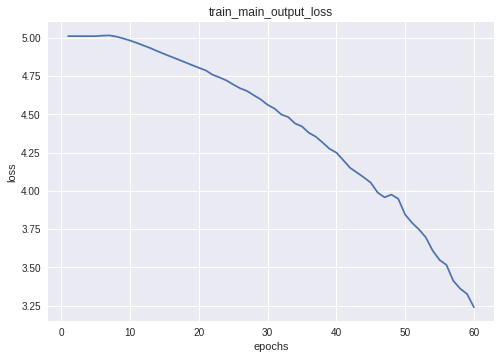

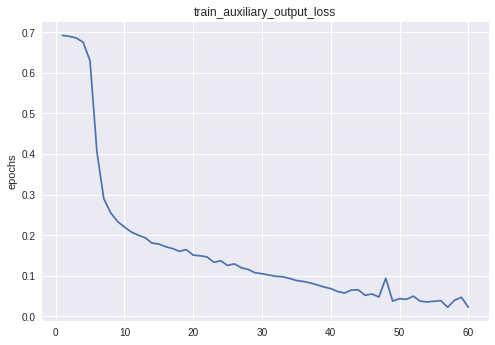

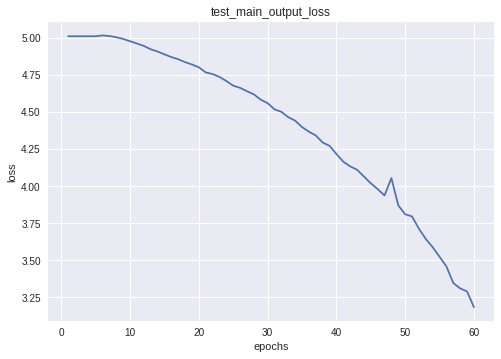

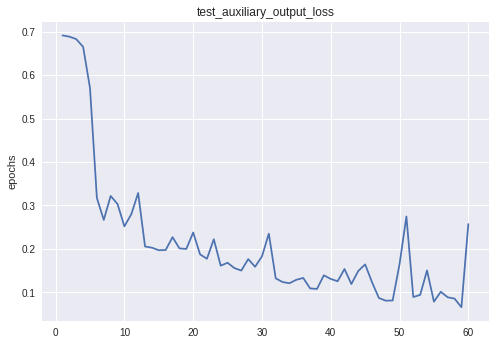

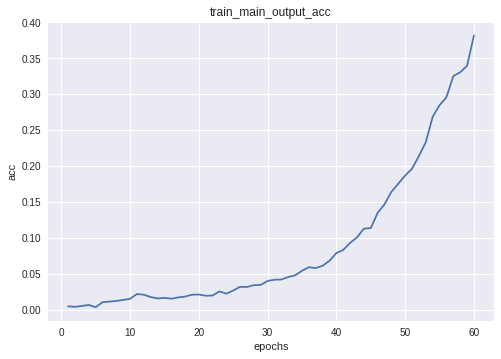

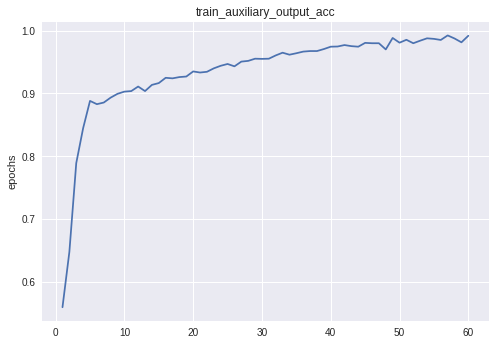

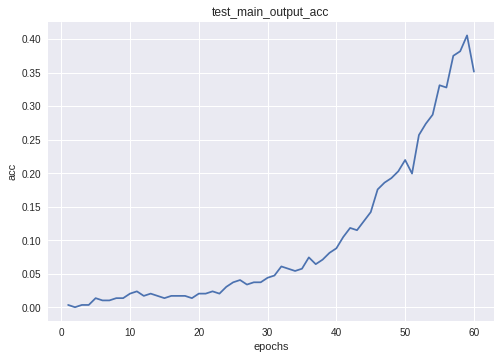

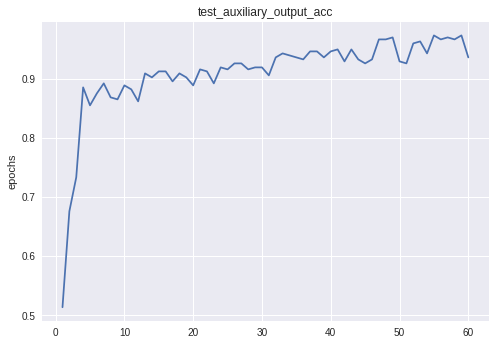

In [5]:
#score = model.evaluate(x_test, y_test, verbose=0)
score = model.evaluate(x_test, [y_test,y_test_ff], verbose=0)


print('Test loss:', score[0])
print('Test accuracy:', score[1])

# plot the data loss
train_main_output_loss=hist_r.history['main_output_loss']
train_auxiliary_output_loss=hist_r.history['auxiliary_output_loss']
X=np.linspace(1,epochs,epochs)
plt.plot(X, train_main_output_loss)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('train_main_output_loss')
plt.show()

plt.plot(X, train_auxiliary_output_loss)
plt.ylabel('loss')
plt.ylabel('epochs')
plt.title('train_auxiliary_output_loss')
plt.show()

test_main_output_loss=hist_r.history['val_main_output_loss']
test_auxiliary_output_loss=hist_r.history['val_auxiliary_output_loss']
X=np.linspace(1,epochs,epochs)
plt.plot(X, test_main_output_loss)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('test_main_output_loss')
plt.show()

plt.plot(X, test_auxiliary_output_loss)
plt.ylabel('loss')
plt.ylabel('epochs')
plt.title('test_auxiliary_output_loss')
plt.show()


# plot the data acc
train_main_output_acc=hist_r.history['main_output_acc']
train_auxiliary_output_acc=hist_r.history['auxiliary_output_acc']
X=np.linspace(1,epochs,epochs)
plt.plot(X, train_main_output_acc)
plt.ylabel('acc')
plt.xlabel('epochs')
plt.title('train_main_output_acc')
plt.show()

plt.plot(X, train_auxiliary_output_acc)
plt.ylabel('acc')
plt.ylabel('epochs')
plt.title('train_auxiliary_output_acc')
plt.show()

test_main_output_acc=hist_r.history['val_main_output_acc']
test_auxiliary_output_acc=hist_r.history['val_auxiliary_output_acc']
X=np.linspace(1,epochs,epochs)
plt.plot(X, test_main_output_acc)
plt.ylabel('acc')
plt.xlabel('epochs')
plt.title('test_main_output_acc')
plt.show()

plt.plot(X, test_auxiliary_output_acc)
plt.ylabel('acc')
plt.ylabel('epochs')
plt.title('test_auxiliary_output_acc')
plt.show()

model.save('/content/drive/My Drive/Project/change_size_l2_yosef_weight_decay.h5')

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 150, 220, 1)  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 37, 54, 96)   2496        main_input[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 18, 26, 96)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 18, 26, 256)  221440      max_pooling2d_4[0][0]            
__________________________________________________________________________________________________
max_poolin

In [6]:
#main_input = Input(shape=(150, 220,1), name='main_input')

new_model = Sequential()
for layer in model.layers[:-2]: # just exclude last layer from copying
  new_model.add(layer)
for layer in model.layers:
  layer.trainable = False
new_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 37, 54, 96)        2496      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 26, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 26, 256)       221440    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 12, 256)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 12, 384)        885120    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 12, 384)        1327488   
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 12, 256)        884992    
__________

In [0]:
#n=new_model.predict(x_train, batch_size=None, verbose=0, steps=None)
#print(n.shape)
#print(n)
#print(type(n))


In [0]:
#print(y_train_for_svm)      
#uniques = []
#for arr in y_train_for_svm:
#    if not any(np.array_equal(arr, y_train_for_svm) for y_train_for_svm in uniques):
#        uniques.append(int(arr))
#print(n)
#print("hi")
#print(n[[0,2],:])
#print("hi2")
#print(uniques)
#iu=[int(ji==57) for ji in uniques]
  
#b=0
#pos_location=list()
#neg_location=list()
#for item in uniques:
#    if item == 64:
#        pos_location.append(b)
#    else:
#        neg_location.append(b)
#    b=b+1
#print(neg_location)
#print(n[pos_location,:])


In [7]:
#X = [[0], [1], [2], [3]]
#Y = [0, 1, 2, 3]
from sklearn import svm

tmp = os.popen("ls drive/'My Drive'/Project/train2/").read().split()
#type(tmp)
num_of_img=0
for line in tmp:
  if 'original' in line:
    num_of_img= num_of_img+1
    
x_train_for_svm=np.ones((num_of_img, 150,220)) # may neet to be x=np.ones((num_of_img, 150,220,1)) but puts an error
y_train_for_svm=np.zeros((num_of_img,1))

i=0 
#print(tmp[1320])

#print(len(tmp))
for line in tmp:
  if 'original' in line:
    path="drive/My Drive/Project/train2/"+line
    img = cv2.imread(path,0)
    # Otsu's thresholding
    ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    #new image
    new_img=255-img

    #resize the img
    newimg = cv2.resize(new_img,(int(220),int(150)))
    #newimg = cv2.resize(new_img,(int(150),int(220)))
    #print(line)
    print(i)
    x_train_for_svm[i,:,:]=newimg
    line_splited=line.split('_')
    y_train_for_svm[i,:]=int(line_splited[1])-1
   # print(y_train[i])
    i=i+1    
    #print(y_train)

    
img_rows, img_cols = 150,220
if K.image_data_format() == 'channels_first':
    x_train_for_svm = x_train_for_svm.reshape(x_train_for_svm.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train_for_svm = x_train_for_svm.reshape(x_train_for_svm.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train_for_svm = x_train_for_svm.astype('float32')/255
    
    

 



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [8]:
features=new_model.predict(x_train_for_svm, batch_size=None, verbose=0, steps=None)

print(y_train_for_svm)
uniques=[]
for arr in y_train_for_svm:
#  if not any(np.array_equal(arr, y_train_for_svm) for y_train_for_svm in uniques):
  uniques.append(int(arr))
print(uniques)
tot_number_of_class=np.max(uniques)+1
print(tot_number_of_class)


[[9.]
 [9.]
 [9.]
 ...
 [8.]
 [8.]
 [8.]]
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 0, 10, 0, 10, 0, 10, 0, 10, 0, 10, 0, 10, 0, 10, 0, 10, 0, 0, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 0, 11, 11, 11, 11, 11, 11, 0, 11, 0, 11, 0, 11, 11, 11, 11, 11, 11, 0, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 0, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 0, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 0, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 0, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 0, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 0, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 

In [9]:
    

#print(y_train_for_svm)      
#uniques = []

#for arr in y_train_for_svm:
#  if not any(np.array_equal(arr, y_train_for_svm) for y_train_for_svm in uniques):
#  uniques.append(int(arr))
  
#print(uniques)
objs = list()
#y_train_new=list() 
for g in range(tot_number_of_class):  # = 0...(len(y_train_for_svm)-1)
#*********** rbf svm**************
  Y=[int(indx==g) for indx in uniques]
  P=np.count_nonzero(Y, axis=None)
  print(P)
  N=len(Y)-P
  print(N)
  skew=N/P
  print(skew)

  clf = svm.SVC(kernel='rbf',gamma=2**(-11),decision_function_shape='ovo',class_weight={1: skew})
  #print(Y)
  #print(len(features))
  clf.fit(features, Y) 
  #dec = clf.decision_function([[1]])
  ###lin_clf = svm.LinearSVC() # add  decision_function_shape='ovo'?
  ###lin_clf.fit(features, Y) 
  #objs.append(clf)
  print(g)
  ###objs.insert(g,lin_clf)
  objs.insert(g,clf)



24
1729
72.04166666666667
0
24
1729
72.04166666666667
1
24
1729
72.04166666666667
2
24
1729
72.04166666666667
3
24
1729
72.04166666666667
4
24
1729
72.04166666666667
5
24
1729
72.04166666666667
6
24
1729
72.04166666666667
7
24
1729
72.04166666666667
8
24
1729
72.04166666666667
9
24
1729
72.04166666666667
10
24
1729
72.04166666666667
11
24
1729
72.04166666666667
12
24
1729
72.04166666666667
13
24
1729
72.04166666666667
14
24
1729
72.04166666666667
15
24
1729
72.04166666666667
16
24
1729
72.04166666666667
17
24
1729
72.04166666666667
18
24
1729
72.04166666666667
19
24
1729
72.04166666666667
20
24
1729
72.04166666666667
21
24
1729
72.04166666666667
22
24
1729
72.04166666666667
23
24
1729
72.04166666666667
24
24
1729
72.04166666666667
25
24
1729
72.04166666666667
26
24
1729
72.04166666666667
27
24
1729
72.04166666666667
28
24
1729
72.04166666666667
29
24
1729
72.04166666666667
30
24
1729
72.04166666666667
31
24
1729
72.04166666666667
32
24
1729
72.04166666666667
33
24
1729
72.0416666666666

In [10]:
pred_err=[]
pred_correct=[]

#Y=[int(indx==9) for indx in uniques]
#print(Y)
sum_correct_pred=0
sum_err_pred=0
print(features.shape[0])
#print(features[[0,1,2,55,666,1000],:])
for ii in range(tot_number_of_class):
  for jj in range(features.shape[0]):
    pred=objs[ii].predict([features[jj,:]])
    if pred==1 and ii==uniques[jj]:
      sum_correct_pred=sum_correct_pred+1
    elif pred==1 and ii!=uniques[jj]:
      sum_err_pred=sum_err_pred +1
  Y=[int(indx==ii) for indx in uniques]
  P=np.count_nonzero(Y, axis=None)
  #N=len(Y)-P
  pred_correct.insert(ii,(sum_correct_pred/P)*100)
  pred_err.insert(ii,sum_err_pred)
  
  sum_correct_pred=0
  sum_err_pred=0
print('success % for every user')
print(pred_correct)
print('False Alarm for every user')
print(pred_err)

1753
success % for every user
[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 95.83333333333334, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
False Alarm for every user
[155, 124, 63, 93, 167, 91, 26, 207, 65, 51, 36, 32, 158, 35, 203, 85, 7, 43, 42, 128, 80, 78, 51, 43, 29, 27, 0, 48, 56, 34, 4, 171, 53, 28, 133, 167, 35, 36, 121, 79, 37, 191, 65, 57, 183, 39, 53, 54, 103, 172, 37, 97, 151, 178, 118, 40, 4, 2, 1, 2, 23, 10, 0, 22, 11, 0, 1, 11, 0, 0, 0, 0, 0, 0, 0]


In [12]:
#  testing te svm
#Y = [0, 1, 2, 3]
#from sklearn import svm

tmp = os.popen("ls drive/'My Drive'/Project/train2/").read().split()
#type(tmp)
num_of_img=0
for line in tmp:
  if 'original' in line:
    num_of_img= num_of_img+1
    
x_test_for_svm=np.ones((num_of_img, 150,220)) # may neet to be x=np.ones((num_of_img, 150,220,1)) but puts an error
y_test_for_svm=np.zeros((num_of_img,1))

i=0 
#print(tmp[1320])

#print(len(tmp))
for line in tmp:
  if 'original' in line:
    path="drive/My Drive/Project/train2/"+line
    img = cv2.imread(path,0)
    # Otsu's thresholding
    ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    #new image
    new_img=255-img

    #resize the img
    newimg = cv2.resize(new_img,(int(220),int(150)))
    #newimg = cv2.resize(new_img,(int(150),int(220)))
    #print(line)
    print(i)
    x_test_for_svm[i,:,:]=newimg
    line_splited=line.split('_')
    y_test_for_svm[i,:]=int(line_splited[1])-1
   # print(y_train[i])
    i=i+1    
    #print(y_train)

    
img_rows, img_cols = 150,220
if K.image_data_format() == 'channels_first':
    x_test_for_svm = x_test_for_svm.reshape(x_test_for_svm.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_test_for_svm = x_test_for_svm.reshape(x_test_for_svm.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_test_for_svm = x_test_for_svm.astype('float32')/255
    
features_test=new_model.predict(x_test_for_svm, batch_size=None, verbose=0, steps=None)

print(y_test_for_svm)
uniques_test=[]
for arr in y_test_for_svm:
#  if not any(np.array_equal(arr, y_train_for_svm) for y_train_for_svm in uniques):
  uniques_test.append(int(arr))
print(uniques_test)
tot_number_of_class_test=np.max(uniques_test)+1
print(tot_number_of_class_test)
    
pred_err=[]
pred_correct=[]

#Y=[int(indx==9) for indx in uniques]
#print(Y)
sum_correct_pred=0
sum_err_pred=0
print(features_test.shape[0])
#print(features[[0,1,2,55,666,1000],:])
for ii in range(tot_number_of_class_test):
  for jj in range(features_test.shape[0]):
    pred=objs[ii].predict([features_test[jj,:]])
    if pred==1 and ii==uniques_test[jj]:
      sum_correct_pred=sum_correct_pred+1
    elif pred==1 and ii!=uniques_test[jj]:
      sum_err_pred=sum_err_pred +1
  Y=[int(indx==ii) for indx in uniques_test]
  P=np.count_nonzero(Y, axis=None)
  print(Y)
  print(P)
  #N=len(Y)-P
  pred_err.insert(ii,sum_err_pred)
  try:
    pred_correct.insert(ii,(sum_correct_pred/P)*100)
  except:
    print('err')
  sum_correct_pred=0
  sum_err_pred=0
print('success % for every user')
print(pred_correct)
print('False Alarm for every user')
print(pred_err)
 



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [14]:
#  testing te svm
#Y = [0, 1, 2, 3]
#from sklearn import svm

tmp = os.popen("ls drive/'My Drive'/Project/test2/").read().split()
#type(tmp)
num_of_img=0
for line in tmp:
  if 'original' in line:
    num_of_img= num_of_img+1
    
x_test_for_svm=np.ones((num_of_img, 150,220)) # may neet to be x=np.ones((num_of_img, 150,220,1)) but puts an error
y_test_for_svm=np.zeros((num_of_img,1))

i=0 
#print(tmp[1320])

#print(len(tmp))
for line in tmp:
  if 'original' in line:
    path="drive/My Drive/Project/test2/"+line
    img = cv2.imread(path,0)
    # Otsu's thresholding
    ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    #new image
    new_img=255-img

    #resize the img
    newimg = cv2.resize(new_img,(int(220),int(150)))
    #newimg = cv2.resize(new_img,(int(150),int(220)))
    #print(line)
    print(i)
    x_test_for_svm[i,:,:]=newimg
    line_splited=line.split('_')
    y_test_for_svm[i,:]=int(line_splited[1])-1
   # print(y_train[i])
    i=i+1    
    #print(y_train)

    
img_rows, img_cols = 150,220
if K.image_data_format() == 'channels_first':
    x_test_for_svm = x_test_for_svm.reshape(x_test_for_svm.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_test_for_svm = x_test_for_svm.reshape(x_test_for_svm.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_test_for_svm = x_test_for_svm.astype('float32')/255
    
features_test=new_model.predict(x_test_for_svm, batch_size=None, verbose=0, steps=None)

print(y_test_for_svm)
uniques_test=[]
for arr in y_test_for_svm:
#  if not any(np.array_equal(arr, y_train_for_svm) for y_train_for_svm in uniques):
  uniques_test.append(int(arr))
print(uniques_test)
tot_number_of_class_test=np.max(uniques_test)+1
print(tot_number_of_class_test)
    
pred_err=[]
pred_correct=[]

#Y=[int(indx==9) for indx in uniques]
#print(Y)
sum_correct_pred=0
sum_err_pred=0
print(features_test.shape[0])
#print(features[[0,1,2,55,666,1000],:])
for ii in range(tot_number_of_class_test):
  for jj in range(features_test.shape[0]):
    pred=objs[ii].predict([features_test[jj,:]])
    if pred==1 and ii==uniques_test[jj]:
      sum_correct_pred=sum_correct_pred+1
    elif pred==1 and ii!=uniques_test[jj]:
      sum_err_pred=sum_err_pred +1
  Y=[int(indx==ii) for indx in uniques_test]
  P=np.count_nonzero(Y, axis=None)
  print(Y)
  print(P)
  #N=len(Y)-P
  pred_err.insert(ii,sum_err_pred)
  try:
    pred_correct.insert(ii,(sum_correct_pred/P)*100)
  except:
    print('err')
  sum_correct_pred=0
  sum_err_pred=0
print('success % for every user')
print(pred_correct)
print('False Alarm for every user')
print(pred_err)
 



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
[[ 9.]
 [ 9.]
 [10.]
 [10.]
 [11.]
 [11.]
 [ 0.]
 [ 0.]
 [12.]
 [12.]
 [13.]
 [13.]
 [14.]
 [14.]
 [15.]
 [15.]
 [16.]
 [16.]
 [17.]
 [17.]
 [18.]
 [18.]
 [19.]
 [19.]
 [20.]
 [20.]
 [ 1.]
 [21.]
 [ 1.]
 [21.]
 [22.]
 [22.]
 [23.]
 [23.]
 [24.]
 [24.]
 [25.]
 [25.]
 [26.]
 [26.]
 [27.]
 [27.]
 [28.]
 [28.]
 [29.]
 [29.]
 [30.]
 [30.]
 [31.]
 [31.]
 [ 2.]
 [ 2.]
 [32.]
 [32.]
 [33.]
 [33.]
 [34.]
 [34.]
 [35.]
 [35.]
 [36.]
 [36.]
 [37.]
 [37.]
 [38.]
 [38.]
 [39.]
 [39.]
 [40.]
 [40.]
 [41.]
 [41.]
 [ 3.]